In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
# Create a dataset.
import pathlib

csv_file = '/Users/qtran/Desktop/my_keras/raw_data/UMAP_ACT_20Kprobes_PCA.csv'
probe_file = '/Users/qtran/Desktop/my_keras/raw_data/ACT-Control-noOutliers-top20K-450K.csv'

clin_data = pd.read_csv(csv_file, header=0, index_col=0, usecols = ['Sample','UMAP1', 'UMAP2', 'Gender', 'Group'])
probe_data = pd.read_csv(probe_file, header=0, index_col=0)

In [4]:
cleanup_nums = {"Group":     {"A1": 1, "A2": 2, "Control": 0}}

clin_data = clin_data.replace(cleanup_nums) 

In [17]:
probe_data_t = probe_data.T
data_merge = probe_data_t.merge(clin_data['Group'], left_on = probe_data_t.index, right_on='Sample')
data_merge = data_merge.set_index('Sample')

probe_data_t = np.array(data_merge)
data = probe_data_t[0:, 0:20000]

labels = data_merge['Group']

num_classes = 3
labels_one_hot = keras.utils.to_categorical(labels, num_classes)


In [6]:
n_inputs = 20000
def create_model():
    model = keras.Sequential()

    model.add(keras.layers.Dense(200, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(keras.layers.Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(keras.layers.Dense(3, activation="softmax"))
    
    model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', 
                  metrics=['accuracy', 'Precision','Recall', 'mae', 'mse'])
    
    return model



In [38]:
def cross_validate(model, data_x, data_y, cv):
    cvscores = []
    for train_index,test_index in cv.split(data_x):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train,x_test=data_x[train_index],data_x[test_index]
        y_train,y_test=data_y[train_index],data_y[test_index]

        model=create_model()
        model.fit(x_train, y_train,epochs=20, batch_size=5, verbose=0)
        scores = model.evaluate(x_test, y_test, verbose=0)
        cvscores.append(scores)
        #print(list(zip(model.metrics_names, np.round(scores,2))))
    return pd.DataFrame(cvscores, columns=model.metrics_names)

In [36]:
from sklearn.model_selection import RepeatedKFold

seed = 12345
n_split=3
n_repeat=10

perm = np.random.permutation(len(labels))

data_x = data[perm]
data_y = labels_one_hot[perm]

train_x = data_x[:47,:]
train_y = data_y[:47,:]



In [37]:
rkfold = RepeatedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=seed)

model = create_model()
results = cross_validate(model, train_x, train_y, rkfold)

TRAIN: [ 0  1  3  4  5  6  7  9 10 11 13 14 15 16 17 18 19 23 26 27 29 32 34 36
 37 40 41 43 44 45 46] TEST: [ 2  8 12 20 21 22 24 25 28 30 31 33 35 38 39 42]
TRAIN: [ 1  2  8  9 11 12 14 16 20 21 22 24 25 27 28 29 30 31 33 34 35 36 37 38
 39 41 42 43 44 45 46] TEST: [ 0  3  4  5  6  7 10 13 15 17 18 19 23 26 32 40]
TRAIN: [ 0  2  3  4  5  6  7  8 10 12 13 15 17 18 19 20 21 22 23 24 25 26 28 30
 31 32 33 35 38 39 40 42] TEST: [ 1  9 11 14 16 27 29 34 36 37 41 43 44 45 46]
TRAIN: [ 0  3  5  6  7 10 11 12 14 16 17 18 19 20 21 22 23 24 25 26 27 30 32 33
 34 36 38 40 44 45 46] TEST: [ 1  2  4  8  9 13 15 28 29 31 35 37 39 41 42 43]
TRAIN: [ 1  2  4  5  8  9 10 12 13 14 15 16 18 19 22 24 27 28 29 31 32 33 35 36
 37 38 39 41 42 43 45] TEST: [ 0  3  6  7 11 17 20 21 23 25 26 30 34 40 44 46]
TRAIN: [ 0  1  2  3  4  6  7  8  9 11 13 15 17 20 21 23 25 26 28 29 30 31 34 35
 37 39 40 41 42 43 44 46] TEST: [ 5 10 12 14 16 18 19 22 24 27 32 33 36 38 45]
TRAIN: [ 0  1  2  4  5  7  8  9 11 12 13 15 18

TRAIN: [ 0  1  5  6  8 11 12 13 14 18 19 21 22 24 25 26 27 28 30 31 32 33 34 35
 36 38 41 42 43 45 46] TEST: [ 2  3  4  7  9 10 15 16 17 20 23 29 37 39 40 44]
TRAIN: [ 2  3  4  5  7  9 10 11 12 14 15 16 17 19 20 23 24 25 29 30 32 34 35 37
 39 40 41 42 44 45 46] TEST: [ 0  1  6  8 13 18 21 22 26 27 28 31 33 36 38 43]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 15 16 17 18 20 21 22 23 26 27 28 29 31
 33 36 37 38 39 40 43 44] TEST: [ 5 11 12 14 19 24 25 30 32 34 35 41 42 45 46]
TRAIN: [ 0  2  3  5  7  8  9 10 11 12 13 14 16 17 19 20 22 23 24 25 27 28 33 34
 39 41 42 43 44 45 46] TEST: [ 1  4  6 15 18 21 26 29 30 31 32 35 36 37 38 40]
TRAIN: [ 0  1  3  4  6 10 12 14 15 16 17 18 21 25 26 27 29 30 31 32 34 35 36 37
 38 39 40 43 44 45 46] TEST: [ 2  5  7  8  9 11 13 19 20 22 23 24 28 33 41 42]
TRAIN: [ 1  2  4  5  6  7  8  9 11 13 15 18 19 20 21 22 23 24 26 28 29 30 31 32
 33 35 36 37 38 40 41 42] TEST: [ 0  3 10 12 14 16 17 25 27 34 39 43 44 45 46]
TRAIN: [ 0  2  3  6  7  8 11 12 13 14 15 16 17

TRAIN: [ 1  2  3  4  5  6  7 11 13 14 15 16 17 19 20 21 22 24 25 27 30 31 32 35
 37 39 40 41 43 44 45] TEST: [ 0  8  9 10 12 18 23 26 28 29 33 34 36 38 42 46]
TRAIN: [ 0  3  4  8  9 10 12 14 16 17 18 19 23 25 26 28 29 30 32 33 34 36 37 38
 39 40 41 42 43 45 46] TEST: [ 1  2  5  6  7 11 13 15 20 21 22 24 27 31 35 44]
TRAIN: [ 0  1  2  5  6  7  8  9 10 11 12 13 15 18 20 21 22 23 24 26 27 28 29 31
 33 34 35 36 38 42 44 46] TEST: [ 3  4 14 16 17 19 25 30 32 37 39 40 41 43 45]
TRAIN: [ 0  3  4  6  7  8  9 10 12 15 16 18 22 25 26 27 28 29 32 33 34 35 37 38
 39 40 41 42 43 45 46] TEST: [ 1  2  5 11 13 14 17 19 20 21 23 24 30 31 36 44]
TRAIN: [ 0  1  2  5  7  9 10 11 12 13 14 17 18 19 20 21 23 24 26 27 30 31 32 34
 36 38 39 42 44 45 46] TEST: [ 3  4  6  8 15 16 22 25 28 29 33 35 37 40 41 43]
TRAIN: [ 1  2  3  4  5  6  8 11 13 14 15 16 17 19 20 21 22 23 24 25 28 29 30 31
 33 35 36 37 40 41 43 44] TEST: [ 0  7  9 10 12 18 26 27 32 34 38 39 42 45 46]
TRAIN: [ 0  1  2  4  6  7  8  9 11 13 15 17 18

TRAIN: [ 2  5  7  9 10 11 12 13 14 16 18 19 21 24 26 27 29 30 31 32 33 35 36 37
 38 39 40 41 43 44 46] TEST: [ 0  1  3  4  6  8 15 17 20 22 23 25 28 34 42 45]
TRAIN: [ 0  1  2  3  4  5  6  8 13 14 15 17 19 20 22 23 24 25 28 29 30 31 34 37
 38 39 40 41 42 43 45] TEST: [ 7  9 10 11 12 16 18 21 26 27 32 33 35 36 44 46]
TRAIN: [ 0  1  3  4  6  7  8  9 10 11 12 15 16 17 18 20 21 22 23 25 26 27 28 32
 33 34 35 36 42 44 45 46] TEST: [ 2  5 13 14 19 24 29 30 31 37 38 39 40 41 43]


In [34]:
results.mean()

loss         0.449146
accuracy     0.943472
precision    0.943472
recall       0.943472
mae          0.040019
mse          0.033317
dtype: float64

In [21]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [22]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

[2 0 2 0 0 0 0 0 0 0 0 0] [1 2 1 2 2 2 2 2 2 2 2 0]


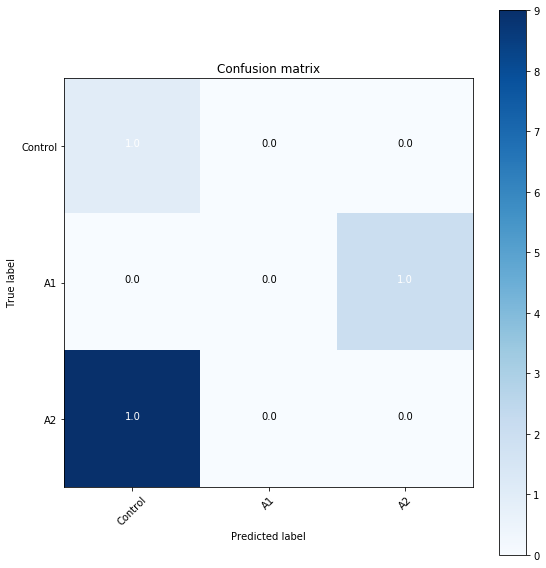

In [39]:
test_x = data_x[48:60,:]
test_y = data_y[48:60,:]

labels_p = model.predict(test_x)

y_predict= np.argmax(labels_p, axis=1)
y_true = np.argmax(test_y, axis =1 )

print(y_predict, y_true)
cm = metrics.confusion_matrix(y_true, y_predict)
figure = plot_confusion_matrix(cm, class_names=['Control', 'A1', 'A2'])



In [40]:
cm

array([[1, 0, 0],
       [0, 0, 2],
       [9, 0, 0]])

In [14]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix





NameError: name 'test_pred_raw' is not defined